# Percolation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
L = 200 # Size of grid
p = 0.6123 # Probability parameter

In [3]:
def generate_sample(length,prob):
    '''Function to generate a lattice sample'''
    grid = np.random.rand(length,length)
    return np.where(grid < prob, 1, 0)

In [4]:
latt = generate_sample(L,p)
latt

array([[0, 1, 0, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 0, 1, ..., 1, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 0]])

## Cluster Labeling: Hoshen-Kapelman algorithm

In [5]:
class Hoshen_Kapelman:
    ''' Implementation of the Hoshen-kapelman algorithm:
    length: Length of the lattice '''
    def __init__(self, length, lattice):
        self.length = length
        self.cluster_labels = np.zeros((self.length,self.length)) # Array to store the cluster labels
        self.lattice = lattice # Generated lattice
        self.pad_lattice = np.pad(self.lattice, 1, 'constant', constant_values = (0))
    
    def run(self):
        '''Hoshe-Kapelman Algorithm'''
        largest_label = 0 # Label name storage
        for i in range(1, self.pad_lattice.shape[0] - 1): #iterate over rows 
            for j in range(1, self.pad_lattice.shape[1] - 1): # iterate over columns
                if self.pad_lattice[i,j] == 1:  # If occupied
                    left = self.pad_lattice[i, j-1] 
                    upper = self.pad_lattice[i-1, j]
                    if left == 0 and upper == 0:  # left and upper neighbors conditions
                        largest_label += 1
                        self.cluster_labels[i-1,j-1] = largest_label
                    elif left == 1 and upper == 0:
                        self.cluster_labels[i-1,j-1] = self.cluster_labels[i-1,j-2]
                    elif left == 0 and upper == 1:
                        self.cluster_labels[i-1,j-1] = self.cluster_labels[i-2,j-1]
                    else:
                        if self.cluster_labels[i-2,j-1] != self.cluster_labels[i-1,j-2]:
                            min_label = min(self.cluster_labels[i-2,j-1], self.cluster_labels[i-1,j-2])
                            max_label = max(self.cluster_labels[i-2,j-1], self.cluster_labels[i-1,j-2])
                            self.cluster_labels[i-1,j-1] = min_label
                            self.cluster_labels = np.where(self.cluster_labels == max_label, min_label, self.cluster_labels)
                        else:
                            self.cluster_labels[i-1,j-1] = self.cluster_labels[i-2,j-1]
        
        _, relabeled_clusters = np.unique(self.cluster_labels, return_inverse = True)  # relabel the clusters names 
        relabeled_clusters = relabeled_clusters.reshape((self.length,self.length)) 
        
        return relabeled_clusters

In [6]:
test = Hoshen_Kapelman(L, latt)
clusters = test.run()
clusters

array([[  0,   1,   0, ...,   0,  31,  31],
       [  1,   1,   1, ...,  31,  31,   0],
       [  1,   0,   1, ...,  31,   0,  41],
       ...,
       [  0,   0,   0, ..., 885, 885, 885],
       [874, 874,   0, ..., 885, 885, 885],
       [  0, 874, 874, ..., 885, 885,   0]], dtype=int64)

In [7]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys

    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

Number of labels: 908


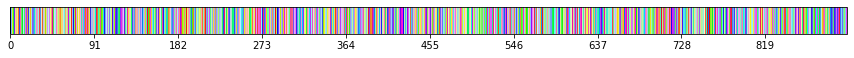

In [8]:
new_cmap = rand_cmap(len(list(set(clusters.flatten()))), type='bright', first_color_black=True, last_color_black=False, verbose=True)

In [9]:
len(list(set(clusters.flatten())))

908

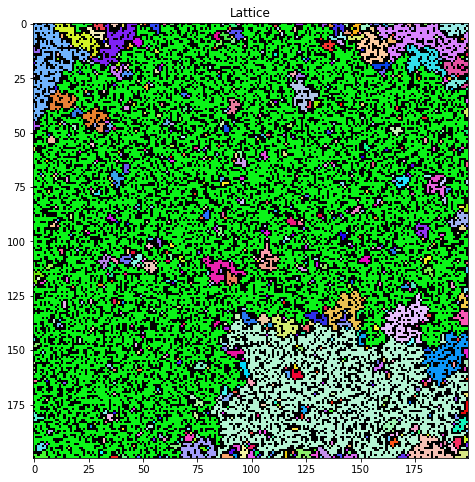

In [10]:
plt.figure(figsize = (8,8))
plt.imshow(clusters, cmap = new_cmap)
plt.title('Lattice')
plt.show()

In [11]:
probs = [0.1, 0.2, 0.3, 0.5, 0.58, 0.6, 0.61, 0.8, 0.9] # probabilities

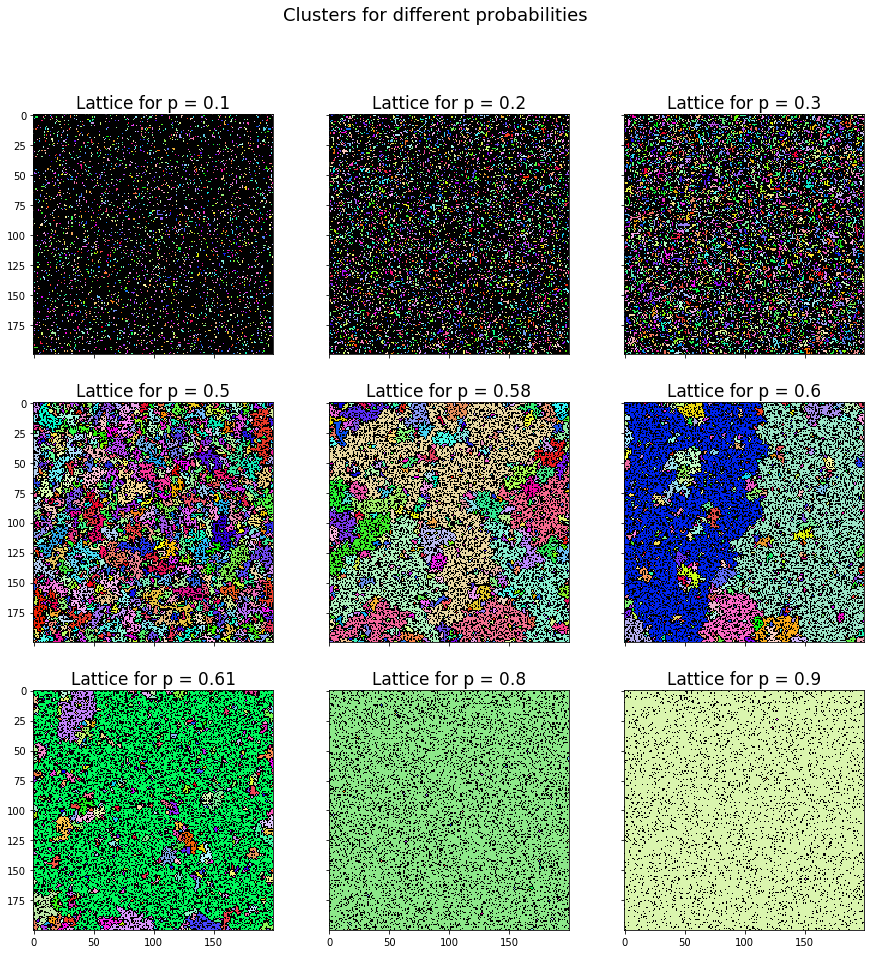

In [12]:
### Create plots of the distribution function at different times

fig, ax = plt.subplots(3, 3,figsize=(15,15))
fig.suptitle('Clusters for different probabilities',fontsize = 18) # general title

ti = 0 # index counter
images = [] # list to store images

for i in range(3): 
    for j in range(3):
        lattice = generate_sample(L,probs[ti])
        clusters_group = Hoshen_Kapelman(L, lattice).run()
        new_cmap = rand_cmap(len(list(set(clusters_group.flatten()))), type='bright',
                             first_color_black=True, last_color_black=False, verbose=False)
        cp = ax[i,j].imshow(clusters_group, cmap = new_cmap)
        ax[i,j].set_title(f'Lattice for p = {probs[ti]}',fontsize = 17) # create title
        images.append(cp) # save contour in list
        ti+=1 

# Hide x labels and tick labels for top plots and y ticks for right plots.
for axx in ax.flat:
    axx.label_outer()